In [82]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

In [83]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing Dataset

###dataset source : https://www.kaggle.com/sauravagarwal/time-series-data

In [84]:
path = "/content/drive/MyDrive/IDCAMP/Project 3 : Time Series/test_ts_data.csv"
df = pd.read_csv(path)
df.shape

(946500, 4)

In [85]:
df.head(5)

,x,y,item,store
0,2015-01-04,51.922151,1,1
1,2015-01-11,39.768148,1,1
2,2015-01-18,24.558860,1,1
3,2015-01-25,40.584438,1,1
4,2015-02-01,15.148615,1,1


In [86]:
df.isnull().sum()

x        0
y        0
item     0
store    0
dtype: int64

# **Disini saya hanya mengambil 20000 sample data agar pemprosesan tidak terlalu lama, dan memenuhi syarat submission yaitu >10000 data**

In [87]:
data_date = df['x'].values[0:20000]
data_value = df['y'].values[0:20000]
print("10% dari SKALA DATA : ",(data_value.max()-data_value.min())*0.1)

10% dari SKALA DATA :  24.776911965427587


Split Dataset

In [92]:
train_size = int(0.8 * len(data_value))
data_train = data_value[:train_size]
data_val = data_value[train_size:]

Window Dataset

In [96]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

train_set = windowed_dataset(data_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(data_val, window_size=60, batch_size=100, shuffle_buffer=1000)

#Plotting Time Series Data

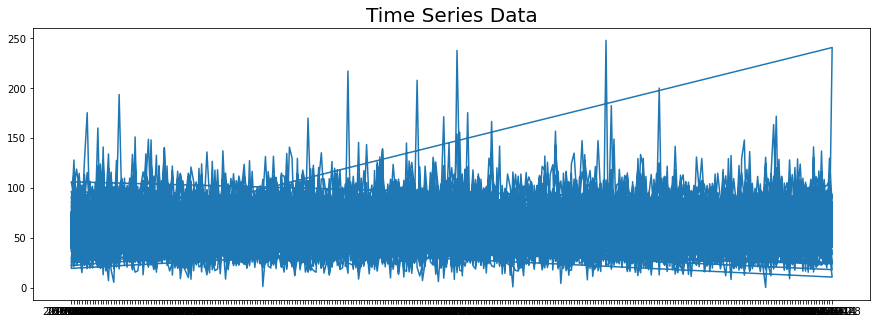

In [97]:
plt.figure(figsize=(15,5))
plt.plot(data_date, data_value)
plt.title('Time Series Data',
          fontsize=20);

# Train and Validation

Model

In [98]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64,  return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [99]:
num_epochs = 50
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='min')
history = model.fit(train_set, epochs=num_epochs, validation_data=val_set, verbose=2, callbacks=early)

Epoch 1/50
160/160 - 20s - loss: 58.2297 - mae: 58.7296 - val_loss: 57.9162 - val_mae: 58.4162
Epoch 2/50
160/160 - 15s - loss: 54.5787 - mae: 55.0787 - val_loss: 49.7361 - val_mae: 50.2360
Epoch 3/50
160/160 - 15s - loss: 27.7045 - mae: 28.2004 - val_loss: 15.8578 - val_mae: 16.3536
Epoch 4/50
160/160 - 15s - loss: 15.5628 - mae: 16.0561 - val_loss: 15.6973 - val_mae: 16.1930
Epoch 5/50
160/160 - 15s - loss: 14.7836 - mae: 15.2762 - val_loss: 12.3220 - val_mae: 12.8134
Epoch 6/50
160/160 - 15s - loss: 13.8118 - mae: 14.3043 - val_loss: 11.5351 - val_mae: 12.0253
Epoch 7/50
160/160 - 15s - loss: 13.0951 - mae: 13.5866 - val_loss: 11.3820 - val_mae: 11.8739
Epoch 8/50
160/160 - 15s - loss: 12.9446 - mae: 13.4364 - val_loss: 10.7646 - val_mae: 11.2538
Epoch 9/50
160/160 - 15s - loss: 12.9606 - mae: 13.4520 - val_loss: 10.8894 - val_mae: 11.3787
Epoch 10/50
160/160 - 15s - loss: 13.0003 - mae: 13.4920 - val_loss: 11.3934 - val_mae: 11.8846
Epoch 11/50
160/160 - 15s - loss: 12.9786 - mae: 

Plot Visualization

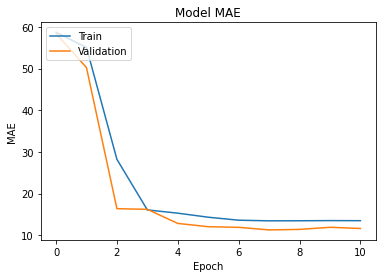

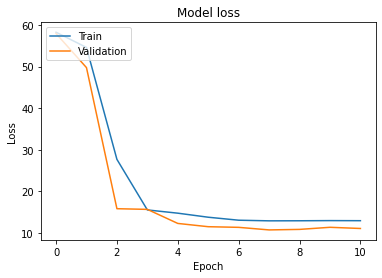

In [100]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

KESIMPULAN : Model sudah cukup baik dalam menangani dataset, terlihat dari MAE dan MAE Validation yang sudah diatas dibawah dari 10% Skala Data.